# Multi-step forecasting: direct approach

In the previous notebooks, we forecasted one step ahead; that is, the CO concentration for the next hour.

In this notebook, we will predict the hourly pollutant concentration for the next 24 hours. That is, we will forecast 24 steps ahead (multi-step forecasting).

We will carry out multi-step forecasting using a direct approach.

## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

# Load data

In [31]:
# Same function we saw in section 2.

def load_data():

    # Data lives here.
    filename = "../datasets/AirQualityUCI_ready.csv"

    # Load data: only the time variable and CO.
    data = pd.read_csv(
        filename,
        usecols=["Date_Time", "CO_sensor", "RH"],
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    data = data["2004-04-01":"2005-04-30"]

    # Remove outliers
    data = data.loc[(data["CO_sensor"] > 0)]

    return data

In [32]:
# Load data.

data = load_data()

data.head()

,CO_sensor,RH
Date_Time,,
2004-04-01 00:00:00,1143.0,61.6
2004-04-01 01:00:00,1044.0,63.9
2004-04-01 02:00:00,1034.0,67.2
2004-04-01 03:00:00,956.0,73.1
2004-04-01 04:00:00,909.0,66.6


# Feature engineering steps

The same pipeline from the previous notebook.

In [33]:
# Datetime features
dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
)

In [34]:
# Lag features.

lagf = LagFeatures(
    variables=["CO_sensor", "RH"],  # the input variables
    freq=["1H", "24H"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)

In [35]:
# Window features

winf = WindowFeatures(
    variables=["CO_sensor", "RH"],  # the input variables
    window="3H",  # average of 3 previous hours
    freq="1H",  # move 1 hr forward
    missing_values="ignore",
)

In [36]:
# Periodic features

cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month", "hour"],
    # Whether to drop the original features.
    drop_original=False,
)

In [37]:
# Drop missing data
imputer = DropMissingData()

In [38]:
# Drop original time series

drop_ts = DropFeatures(features_to_drop=["CO_sensor", "RH"])

# Feature engineering pipeline

In [39]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

# Split data into train and test

We will leave the last month of data as hold-out sample to evaluate the performance of the model.

Remember that we need data about the pollutant information at least 24 hours before the first forecasting point in the test set to create the input features.

In [40]:
# Split the data.

# input data
X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)]

# target
y_train = data[data.index < "2005-03-04"]["CO_sensor"]
y_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)][
    "CO_sensor"
]

# Prepare the target

In the direct approach, we build a model to predict each one of the steps in the forecasting horizon.

This means that we need to create suitable targets first:

- 1 hour ahead
- 2 hour ahead
- 3 hour ahead

...

- 24 hour ahead.

In [52]:
# The forecasting horizon.
horizon = 24

# Create an empty dataframe for the new targets.
y_train_multi = pd.DataFrame(index=y_train.index)
y_test_multi = pd.DataFrame(index=y_test.index)

# Add each one of the steps ahead.
for h in range(horizon):
    y_train_multi[f"h_{h}"] = y_train.shift(periods=-h, freq="H")
    y_test_multi[f"h_{h}"] = y_test.shift(periods=-h, freq="H")

In [53]:
# Each column represents one of the targets.
# Each target represents the number of steps ahead.

y_train_multi.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
Date_Time,,,,,,,,,,,,,,,,,,,,,
2004-04-01 00:00:00,1143.0,1044.0,1034.0,956.0,909.0,996.0,1154.0,1510.0,1722.0,1512.0,...,NaN,NaN,NaN,1308.0,1529.0,1592.0,1536.0,1192.0,1186.0,1203.0
2004-04-01 01:00:00,1044.0,1034.0,956.0,909.0,996.0,1154.0,1510.0,1722.0,1512.0,1258.0,...,NaN,NaN,1308.0,1529.0,1592.0,1536.0,1192.0,1186.0,1203.0,1139.0
2004-04-01 02:00:00,1034.0,956.0,909.0,996.0,1154.0,1510.0,1722.0,1512.0,1258.0,1094.0,...,NaN,1308.0,1529.0,1592.0,1536.0,1192.0,1186.0,1203.0,1139.0,1072.0
2004-04-01 03:00:00,956.0,909.0,996.0,1154.0,1510.0,1722.0,1512.0,1258.0,1094.0,1129.0,...,1308.0,1529.0,1592.0,1536.0,1192.0,1186.0,1203.0,1139.0,1072.0,954.0
2004-04-01 04:00:00,909.0,996.0,1154.0,1510.0,1722.0,1512.0,1258.0,1094.0,1129.0,1125.0,...,1529.0,1592.0,1536.0,1192.0,1186.0,1203.0,1139.0,1072.0,954.0,951.0


In [54]:
# Each column represents one of the targets.
# Each target represents the number of steps ahead.

y_test_multi.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-03-03 00:00:00,1047.0,1030.0,986.0,992.0,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,...,1096.0,1108.0,1124.0,1216.0,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0
2005-03-03 01:00:00,1030.0,986.0,992.0,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,1111.0,...,1108.0,1124.0,1216.0,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0,1213.0
2005-03-03 02:00:00,986.0,992.0,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,1111.0,1165.0,...,1124.0,1216.0,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0,1213.0,1142.0
2005-03-03 03:00:00,992.0,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,1111.0,1165.0,1129.0,...,1216.0,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0,1213.0,1142.0,1089.0
2005-03-03 04:00:00,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,1111.0,1165.0,1129.0,1092.0,...,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0,1213.0,1142.0,1089.0,982.0


When we create our target, we will add some missing data because we obviously don't have all the information that far ahead.

In [55]:
y_train_multi.isnull().sum()

h_0       0
h_1      16
h_2      29
h_3      42
h_4      54
h_5      65
h_6      75
h_7      85
h_8      95
h_9     104
h_10    113
h_11    121
h_12    130
h_13    139
h_14    148
h_15    155
h_16    162
h_17    169
h_18    177
h_19    185
h_20    192
h_21    199
h_22    206
h_23    213
dtype: int64

In [56]:
y_test_multi.isnull().sum()

h_0      0
h_1      2
h_2      3
h_3      4
h_4      5
h_5      6
h_6      7
h_7      8
h_8      9
h_9     10
h_10    11
h_11    12
h_12    13
h_13    14
h_14    15
h_15    16
h_16    17
h_17    18
h_18    19
h_19    20
h_20    21
h_21    22
h_22    23
h_23    24
dtype: int64

In [57]:
# Let's drop the missing data points in the
# target and adjust our training and testing sets.

y_train_multi.dropna(inplace=True)
y_test_multi.dropna(inplace=True)

X_train = X_train.loc[y_train_multi.index]
X_test = X_test.loc[y_test_multi.index]

# Train pipeline and model

We train the engineering steps and the pipeline utilizing the training set.

In [58]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,RH_lag_1H,CO_sensor_lag_24H,RH_lag_24H,CO_sensor_window_3H_mean,RH_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,,,,
2004-04-02 17:00:00,4,14,4,2,17,0,1248.0,22.8,1308.0,27.5,1277.333333,26.866667,0.866025,-0.5,-0.997669,-0.068242
2004-04-02 18:00:00,4,14,4,2,18,0,1382.0,22.3,1529.0,32.1,1303.666667,24.133333,0.866025,-0.5,-0.979084,0.203456
2004-04-02 19:00:00,4,14,4,2,19,0,1491.0,30.1,1592.0,36.7,1373.666667,25.066667,0.866025,-0.5,-0.887885,0.460065
2004-04-02 20:00:00,4,14,4,2,20,0,1620.0,40.1,1536.0,40.9,1497.666667,30.833333,0.866025,-0.5,-0.730836,0.682553
2004-04-02 21:00:00,4,14,4,2,21,0,1693.0,42.5,1192.0,44.0,1601.333333,37.566667,0.866025,-0.5,-0.519584,0.854419


In [59]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)

y_train_t = y_train_multi.loc[X_train_t.index]

print(y_train_t.shape)

(7723,)
(7050, 24)


In [60]:
# Lasso regression

# Using the MultiOutputRegressor, we automatically create
# one Lasso for each target.

lasso = MultiOutputRegressor(Lasso(random_state=0, max_iter=50000))

# Train the model

lasso.fit(X_train_t, y_train_t)

MultiOutputRegressor(estimator=Lasso(max_iter=50000, random_state=0))

In [62]:
# Make predictions

preds = lasso.predict(X_train_t)

# The predictions are made for each one of
# the targets.

preds.shape

(7050, 24)

In [63]:
# Let's capture the predictions in a dataframe
# to determine the RMSE and plot the results.

preds = pd.DataFrame(preds, columns=y_train_t.columns)

preds.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
0,1226.272359,1195.213809,1158.108337,1128.612794,1113.867459,1110.333720,1112.599666,1107.157660,1079.548003,1038.912209,...,1025.906267,1055.125470,1085.596121,1120.199944,1156.792421,1196.057606,1228.456463,1242.633319,1241.006975,1226.690662
1,1384.730117,1321.789060,1235.163412,1159.352565,1110.412688,1084.253586,1075.620028,1070.798029,1055.768390,1036.654200,...,1101.545843,1119.311727,1130.635199,1138.073952,1149.860372,1165.365887,1182.037424,1207.138750,1256.876228,1311.658072
2,1489.739492,1416.642603,1321.230305,1232.891122,1165.311181,1113.828543,1077.464263,1059.326364,1054.614817,1062.287599,...,1189.328083,1202.269458,1213.518959,1215.190725,1212.114017,1205.288071,1202.278156,1226.389324,1287.848539,1353.225503
3,1580.275168,1486.841565,1387.039381,1295.456283,1219.785092,1154.440292,1101.966459,1076.903104,1087.063914,1124.594239,...,1271.714338,1273.832949,1280.448972,1279.059646,1274.014938,1264.787621,1263.777973,1295.827712,1356.664837,1405.424292
4,1562.128516,1428.927047,1328.605474,1249.018897,1187.654689,1136.777010,1100.690970,1084.803103,1115.019147,1182.472087,...,1290.630581,1273.321441,1260.313050,1254.918739,1272.642293,1299.274762,1340.525060,1396.022942,1445.759748,1450.802549


In [64]:
# The RMSE in the train set.

for h in range(horizon):
    rmse = mean_squared_error(preds[f"h_{h}"], y_train_t[f"h_{h}"], squared=False)
    print(f"for horizon {h} got rmse: {rmse}")

for horizon 0 got rmse: 89.28555098123223
for horizon 1 got rmse: 134.4605121618707
for horizon 2 got rmse: 159.84494576695087
for horizon 3 got rmse: 172.9464750992676
for horizon 4 got rmse: 177.70515791440366
for horizon 5 got rmse: 176.1655403720659
for horizon 6 got rmse: 168.91227655462328
for horizon 7 got rmse: 161.52391926170642
for horizon 8 got rmse: 166.73454026066048
for horizon 9 got rmse: 171.596547939493
for horizon 10 got rmse: 169.90382811197372
for horizon 11 got rmse: 168.45985383147968
for horizon 12 got rmse: 171.08286208881105
for horizon 13 got rmse: 176.01830586192798
for horizon 14 got rmse: 181.17170993285472
for horizon 15 got rmse: 184.01177973571194
for horizon 16 got rmse: 182.8799037954065
for horizon 17 got rmse: 178.91390092054655
for horizon 18 got rmse: 177.00075783224415
for horizon 19 got rmse: 174.98444439000414
for horizon 20 got rmse: 167.51060170469427
for horizon 21 got rmse: 158.95937240550856
for horizon 22 got rmse: 158.93245140708916
for h

Notice how the RMSE is worse for those values further into the future. This is normal; predictions about the furthest values in the future always have a greater uncertainty.

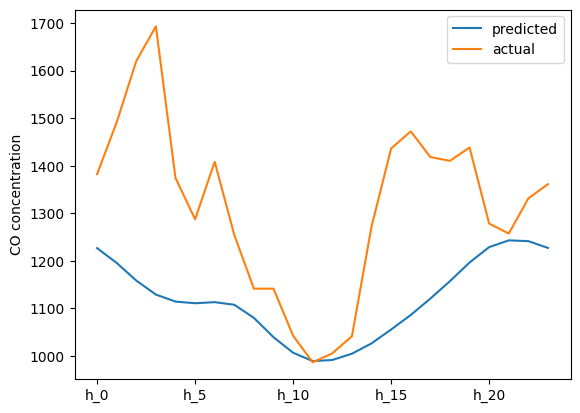

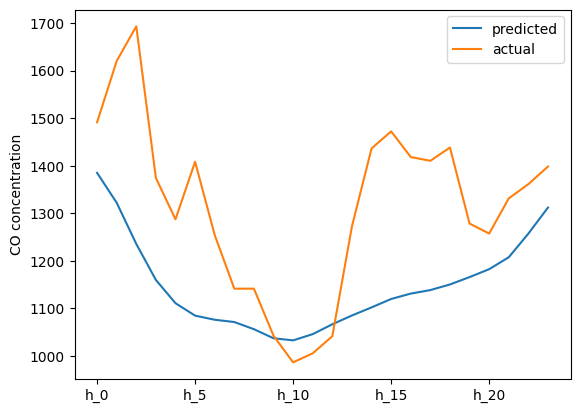

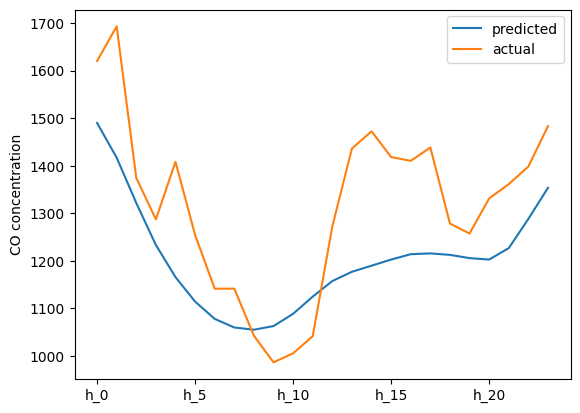

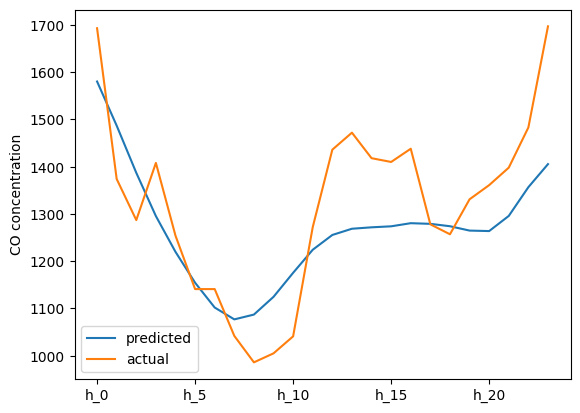

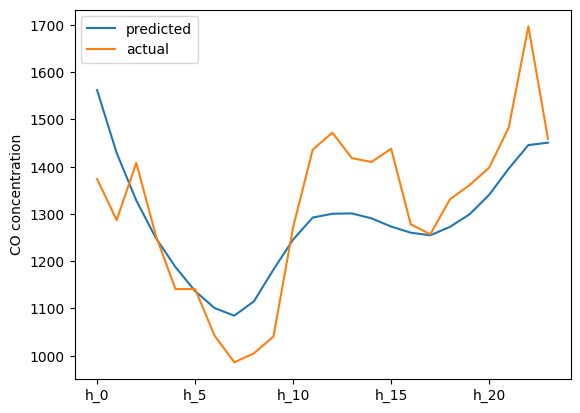

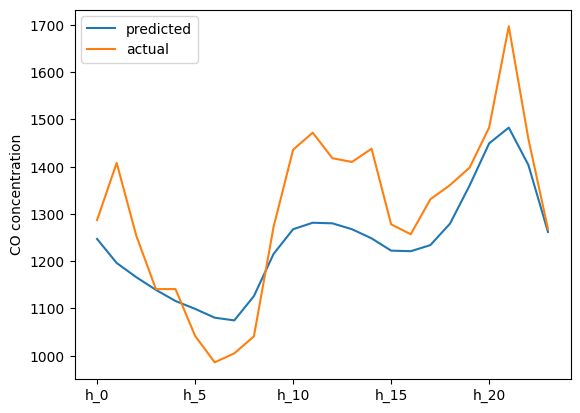

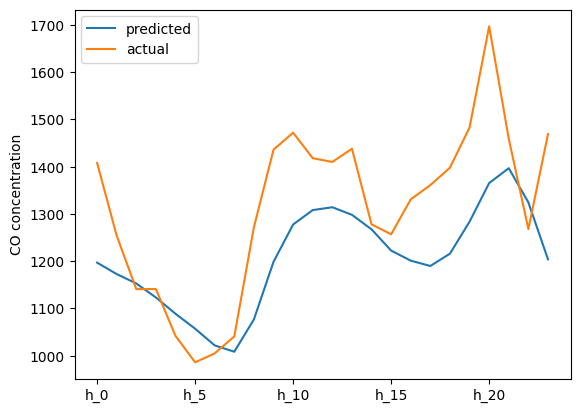

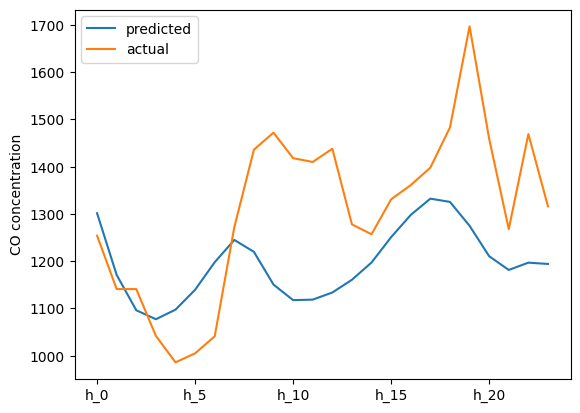

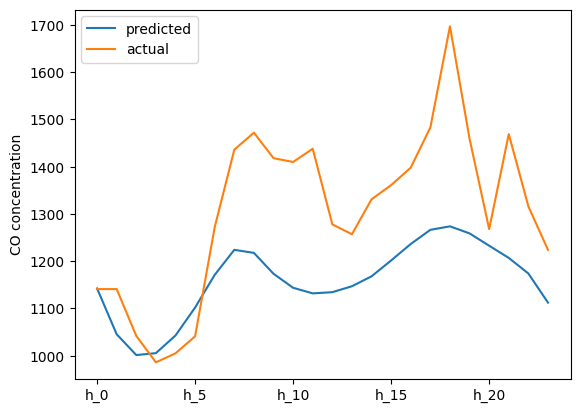

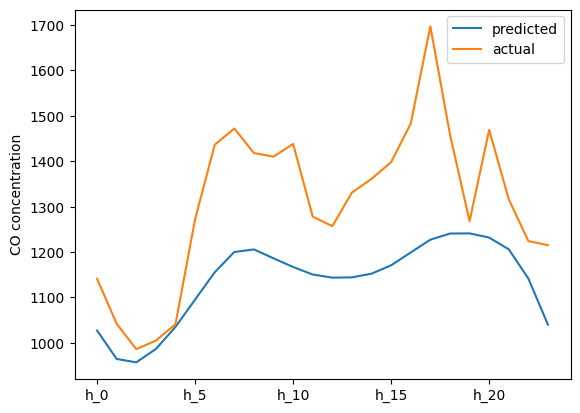

In [65]:
# Let's plot the first ten multistep forecasts
# in the train set.

# Each row corresponds to 24 hr forecasts.

for i in range(0, 10):
    tmp = pd.concat(
        [
            preds.iloc[i].T,
            y_train_t.iloc[i].T,
        ],
        axis=1,
    )

    tmp.columns = ["predicted", "actual"]

    tmp.plot()
    plt.ylabel("CO concentration")
    plt.show()

Our model managed to get the trend of the forecast, but deviates from the real values quite a bit.

Hopefully, by the end of the course we can improve this model with more useful features :)

# Forecast 24 hours ahead in test set

We will evaluate the performance of the model in our test set now.

In [66]:
# Create the input features:

X_test_t = pipe.transform(X_test)

X_test_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,RH_lag_1H,CO_sensor_lag_24H,RH_lag_24H,CO_sensor_window_3H_mean,RH_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,,,,
2005-03-04 00:00:00,3,9,4,4,0,0,1179.0,82.0,1047.0,41.7,1223.333333,82.700000,1.0,6.123234e-17,0.000000,1.000000
2005-03-04 01:00:00,3,9,4,4,1,0,1213.0,80.9,1030.0,43.3,1199.333333,81.800000,1.0,6.123234e-17,0.269797,0.962917
2005-03-04 02:00:00,3,9,4,4,2,0,1142.0,81.2,986.0,45.9,1178.000000,81.366667,1.0,6.123234e-17,0.519584,0.854419
2005-03-04 03:00:00,3,9,4,4,3,0,1089.0,80.9,992.0,49.7,1148.000000,81.000000,1.0,6.123234e-17,0.730836,0.682553
2005-03-04 04:00:00,3,9,4,4,4,0,982.0,70.6,1076.0,56.3,1071.000000,77.566667,1.0,6.123234e-17,0.887885,0.460065


In [67]:
# Make predictions

preds = lasso.predict(X_test_t)

preds.shape

(688, 24)

In [68]:
print(y_test_multi.shape)

# Adjust the target, it has observations
# that were removed from the test set due
# to null values.

y_test_t = y_test_multi.loc[X_test_t.index]

print(y_test_t.shape)

(736, 24)
(688, 24)


In [69]:
# Let's capture the predictions in a dataframe
# to determine the RMSE and plot the results.

preds = pd.DataFrame(preds, columns=y_test_t.columns)

preds.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
0,1132.554487,1078.286866,1048.493903,1052.627830,1092.838910,1159.802140,1249.714166,1323.457336,1306.053417,1222.286445,...,1236.315676,1290.459710,1319.075005,1330.891338,1303.603543,1250.645885,1180.131797,1113.596632,1072.579012,1041.131748
1,1170.436719,1108.030668,1066.890100,1057.771891,1085.301984,1140.965107,1221.865176,1291.519409,1291.021022,1239.381454,...,1262.561835,1290.878764,1292.677135,1278.896666,1240.982939,1187.202812,1125.488209,1077.170688,1065.328749,1066.548929
2,1100.178616,1065.606382,1051.579263,1059.858429,1093.274914,1146.619297,1215.781117,1276.080818,1287.457150,1261.277452,...,1260.629511,1272.212461,1267.591626,1250.690878,1216.846921,1176.094725,1130.253770,1085.626613,1051.085132,1021.869443
3,1057.999002,1047.086245,1051.162300,1068.579751,1102.559758,1150.879732,1208.510466,1259.767266,1280.520524,1275.513435,...,1252.617794,1246.907725,1232.315457,1208.202862,1175.204778,1144.217934,1112.272905,1074.855298,1032.287387,992.467211
4,974.103193,980.983984,985.486934,1000.072817,1036.252294,1096.085362,1167.239452,1225.058991,1256.478596,1264.318261,...,1196.299903,1168.052410,1130.855665,1090.418703,1064.671668,1062.744708,1066.469993,1045.356281,1001.285952,964.698474


In [70]:
# The RMSE in the test set.

for h in range(horizon):
    rmse = mean_squared_error(preds[f"h_{h}"], y_test_t[f"h_{h}"], squared=False)
    print(f"for horizon {h} got rmse: {rmse}")

for horizon 0 got rmse: 86.63278589602952
for horizon 1 got rmse: 133.08197041805818
for horizon 2 got rmse: 159.927896167204
for horizon 3 got rmse: 173.35999640434784
for horizon 4 got rmse: 177.97066474971032
for horizon 5 got rmse: 175.02692740987453
for horizon 6 got rmse: 164.77032114002736
for horizon 7 got rmse: 149.23332665691515
for horizon 8 got rmse: 141.96214622098256
for horizon 9 got rmse: 148.8980174716679
for horizon 10 got rmse: 147.96700931330753
for horizon 11 got rmse: 145.6786643570667
for horizon 12 got rmse: 148.0226491849003
for horizon 13 got rmse: 156.25276714842437
for horizon 14 got rmse: 166.35234951868256
for horizon 15 got rmse: 174.07493738519474
for horizon 16 got rmse: 175.94808922243652
for horizon 17 got rmse: 172.29842423757134
for horizon 18 got rmse: 164.91732679075275
for horizon 19 got rmse: 159.1180334955095
for horizon 20 got rmse: 150.41201217333932
for horizon 21 got rmse: 135.78881328782768
for horizon 22 got rmse: 134.1457824587347
for ho

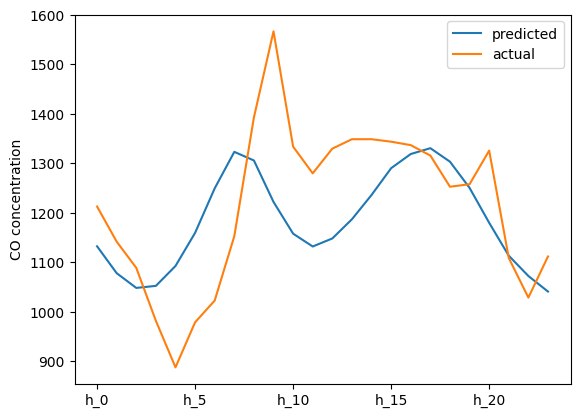

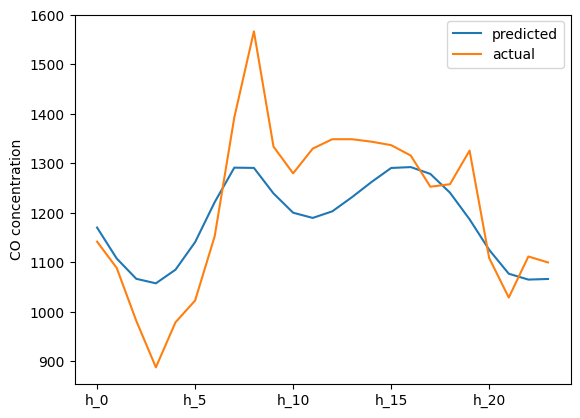

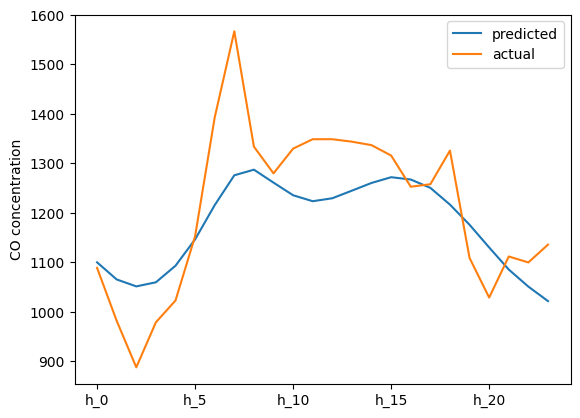

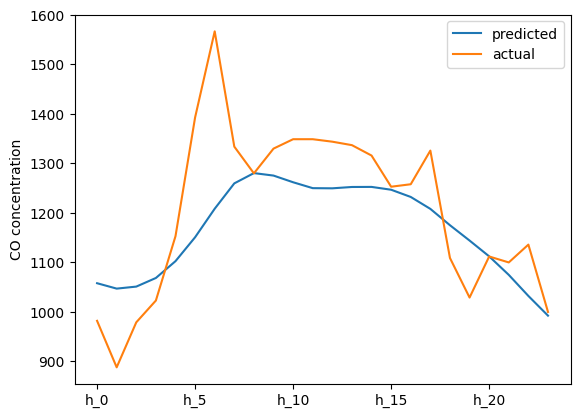

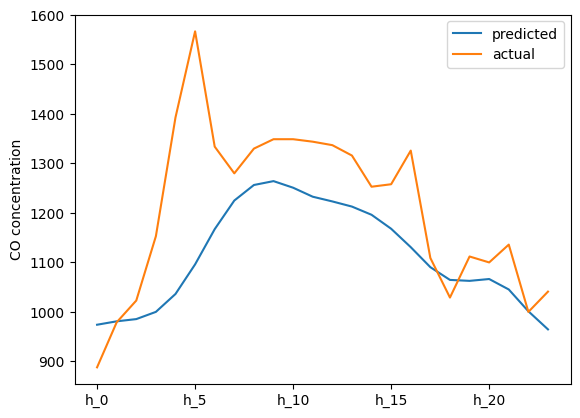

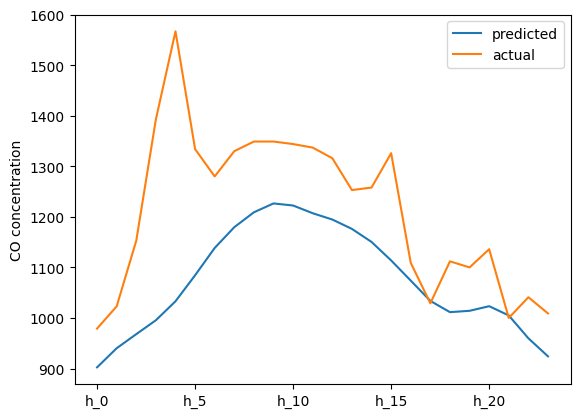

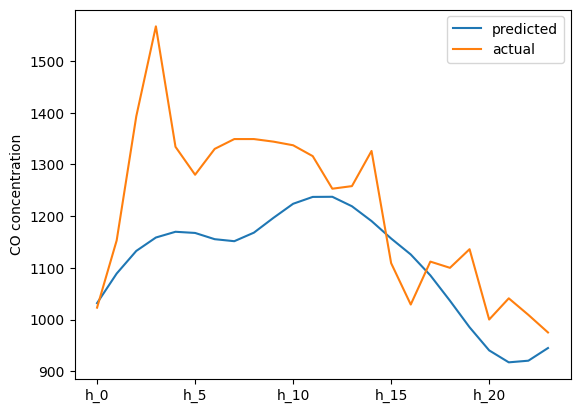

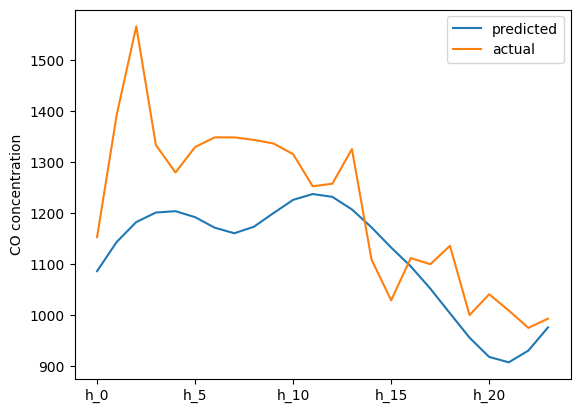

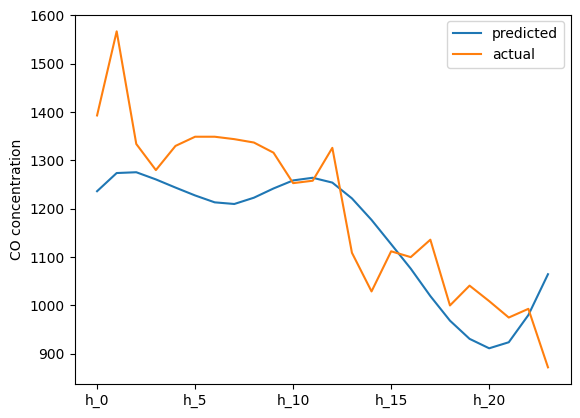

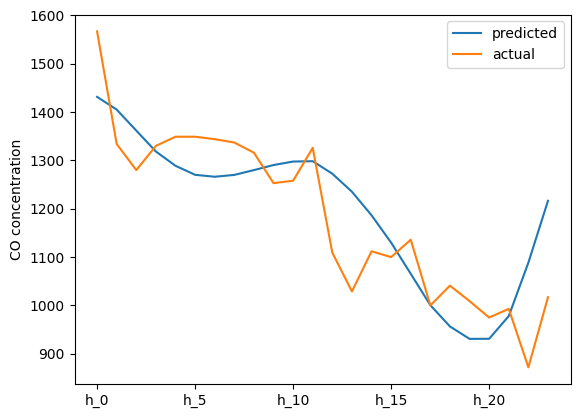

In [71]:
# Let's plot the first ten multistep forecasts
# in the train set.

# Each row corresponds to 24 hr forecasts.

for i in range(0, 10):
    tmp = pd.concat(
        [
            preds.iloc[i].T,
            y_test_t.iloc[i].T,
        ],
        axis=1,
    )

    tmp.columns = ["predicted", "actual"]

    tmp.plot()
    plt.ylabel("CO concentration")
    plt.show()

We've seen how to implement the direct forecasting method to perform multistep forecasting.